# Invoke Bedrock model for code generation

> *This notebook should work well with the **`Data Science 3.0`** kernel in SageMaker Studio*

이 노트북은 AWS의 [Amazon bedrock workshop](https://github.com/aws-samples/amazon-bedrock-workshop/tree/main/01_Text_generation)을 기반으로 작성되었습니다.
## Introduction

이 노트북에서는 텍스트 프롬프트를 기반으로 LLM을 사용하여 코드를 생성하는 방법을 보여줍니다. 우리는 Boto3 API를 사용하여 Bedrock의 Claude v3를 사용할 것입니다.
이 예제에서 사용된 프롬프트는 zero-shot prompt라고 하며, 우리는 prompt 외의 다른 텍스트 예제를 제공하지 않습니다. 

**Note:** *이 노트북은 AWS 환경 내부 또는 외부에서 실행할 수 있습니다.*

#### Context
Amazon Bedrock의 코드 생성 기능을 보여주기 위해, Boto3 클라이언트를 사용하여 Amazon Bedrock API와 통신하는 방법을 살펴볼 것입니다. 사용 가능한 다양한 구성과 간단한 입력이 어떻게 원하는 출력으로 이어지는지를 보여줄 것입니다. 우리는 두 가지 사용 사례에 대한 코드 생성을 탐구할 것입니다.
 1. 분석적 QnA를 위한 Python 코드 생성
 2. SQL 쿼리 생성

#### Pattern
두 사용 사례 모두에서 우리는 단순히 Amazon Bedrock API에 태스크, instruction 및 내부 모델의 입력으로 구성된 입력을 제공할 것입니다. 모델은 추가 예시 없이 출력을 생성할 것입니다. 여기서 목적은 강력한 LLM이 손쉽게 작업을 이해하고 설득력 있는 출력을 생성할 수 있음을 보여주는 것입니다.

<img src="./imgs/bedrock-code-gen.png" width="750" height="650"/>

## Use case 1 - 분석 QnA를 위한 Python 코드 생성
Amazon Bedrock의 모델이 코드를 생성할 수 있는 기능을 보여주기 위해, 기본적인 분석 QnA를 수행하기 위한 Python 코드 생성 사용 사례를 살펴보겠습니다.

#### Persona
당신은 AnyCompany의 데이터 분석가입니다. 회사는 지난 1년 동안 다양한 제품에 대한 판매 실적을 이해하고자 합니다. 여러분은 sales.csv라는 데이터셋을 제공받았습니다. 이 데이터셋에는 다음과 같은 열이 포함되어 있습니다:

- Date (YYYY-MM-DD) 형식
- Product_ID (각 제품에 대한 고유 식별자)
- Price (각 제품이 판매된 가격)

#### Implementation
이 사용 사례를 수행하기 위해, 이 노트북에서는 주어진 프롬프트에 대한 코드를 생성하는 방법을 보여줄 것입니다. 우리는 Amazon Bedrock API와 Boto3 클라이언트를 사용하여 Anthropic Claude v3를 사용할 것입니다.

## Setup


In [1]:
import json
import os
import sys

import boto3
import botocore

boto3_bedrock = boto3.client('bedrock-runtime')

## Code Generation

위에서 설명한 사용 사례를 따르면, 사용 사례에 대한 Python 프로그램을 생성하기 위해 Amazon Bedrock 서비스에 입력할 내용을 준비합니다.

#### Lab setup - create sample sales.csv data for this lab.



In [2]:
# create sales.csv file
import csv

data = [
    ["date", "product_id", "price", "units_sold"],
    ["2023-01-01", "P001", 50, 20],
    ["2023-01-02", "P002", 60, 15],
    ["2023-01-03", "P001", 50, 18],
    ["2023-01-04", "P003", 70, 30],
    ["2023-01-05", "P001", 50, 25],
    ["2023-01-06", "P002", 60, 22],
    ["2023-01-07", "P003", 70, 24],
    ["2023-01-08", "P001", 50, 28],
    ["2023-01-09", "P002", 60, 17],
    ["2023-01-10", "P003", 70, 29],
    ["2023-02-11", "P001", 50, 23],
    ["2023-02-12", "P002", 60, 19],
    ["2023-02-13", "P001", 50, 21],
    ["2023-02-14", "P003", 70, 31],
    ["2023-03-15", "P001", 50, 26],
    ["2023-03-16", "P002", 60, 20],
    ["2023-03-17", "P003", 70, 33],
    ["2023-04-18", "P001", 50, 27],
    ["2023-04-19", "P002", 60, 18],
    ["2023-04-20", "P003", 70, 32],
    ["2023-04-21", "P001", 50, 22],
    ["2023-04-22", "P002", 60, 16],
    ["2023-04-23", "P003", 70, 34],
    ["2023-05-24", "P001", 50, 24],
    ["2023-05-25", "P002", 60, 21]
]

# Write data to sales.csv
with open('sales.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(data)

print("sales.csv has been created!")

sales.csv has been created!


#### Analyzing sales with Amazon Bedrock generated Python program

In [47]:
from langchain_core.messages import HumanMessage

# Create the prompt
# Analyzing sales

content = """
You have a CSV, sales.csv, with columns:
- date (YYYY-MM-DD)
- product_id
- price
- units_sold

Create a python program to analyze the sales data from a CSV file. Skip the preamble and provide only the python without ```python '''.
The program should be able to read the data, and determine below:

- Total revenue for the year
- The product with the highest revenue
- The date with the highest revenue
- Visualize monthly sales using a bar chart

Ensure the code is syntactically correct, bug-free, optimized, not span multiple lines unnessarily, and prefer to use standard libraries. Return only python code without any surrounding text, explanation or context.

"""

messages = [
    HumanMessage(
        content=content
    )
]

#### Invoke the Anthropic Claude v3 model

In [48]:
from langchain_community.chat_models import BedrockChat
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

llm = BedrockChat(
    model_id = "anthropic.claude-3-haiku-20240307-v1:0",
    streaming=True,
    callbacks=[StreamingStdOutCallbackHandler()],
    model_kwargs={
        "anthropic_version": "bedrock-2023-05-31",
        "max_tokens": 4096,
        "temperature" : 0.5,
        "top_k": 250,
        "top_p": 0.5
        # "system": "You're a evaluator that escape all double quotation marks in inputs"
    }
)

result = llm(messages)

import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('sales.csv')
df['date'] = pd.to_datetime(df['date'])

total_revenue = df['price'].sum() * df['units_sold'].sum()
best_product = df.groupby('product_id')['price'].sum().idxmax()
best_date = df.groupby(df['date'].dt.date)['price'].sum().idxmax()

monthly_sales = df.groupby(df['date'].dt.strftime('%Y-%m'))['units_sold'].sum()
monthly_sales.plot(kind='bar', figsize=(12,6))
plt.title('Monthly Sales')
plt.xlabel('Month')
plt.ylabel('Units Sold')
plt.show()

#### (Optional) Execute the Bedrock generated code for validation. Go to text editor to copy the generated code as printed output can be trucncated. Replace the code in below cell.

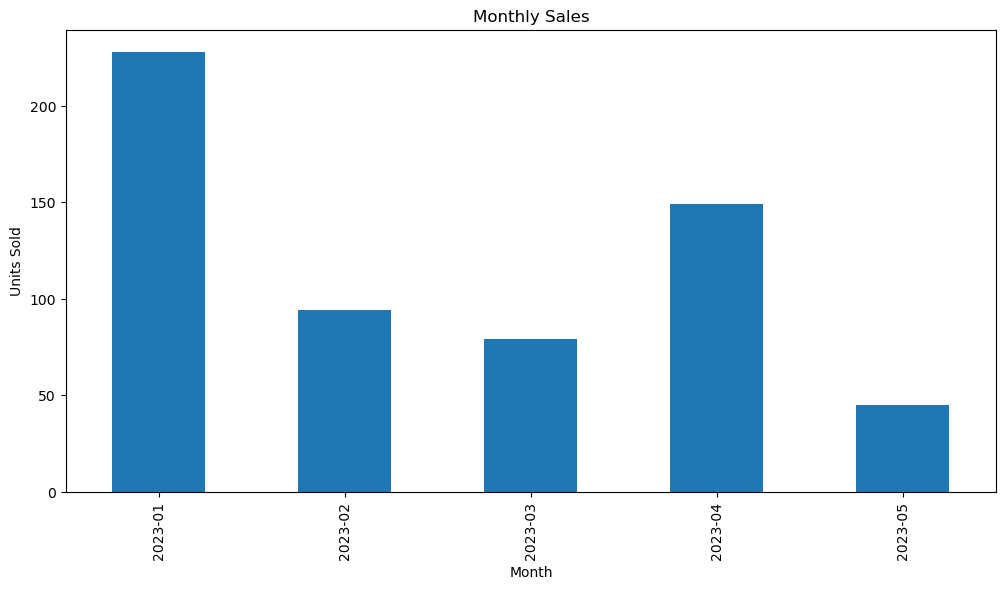

In [49]:
exec(result.content)

___

## Use case 2 - SQL query generation

Amazon Bedrock의 모델 생성 기능을 보여주기 위해 Python을 사용하여 기본적인 분석 QnA를 수행하는 코드 생성 사용 사례를 살펴보겠습니다.
이 섹션에서는 LLM을 사용하여 SQL 쿼리를 생성하여 판매 데이터를 분석하는 방법을 보여드립니다.
Boto3 API를 사용하여 Bedrock의 Claude V3 모델을 사용할 것입니다.
이 예제에서 사용된 prompt는 zero-shot 프롬프트라고 하며, 프롬프트 외에는 텍스트 예시를 제공하지 않습니다.

**Note:** *이 노트북은 AWS 환경 내부 또는 외부에서 실행할 수 있습니다.*

#### Context
Boto3 클라이언트를 사용하여 Amazon Bedrock API와 통신하는 방법을 탐색하여 Amazon Bedrock의 SQL 코드 생성 기능을 보여드리겠습니다. 사용 가능한 다양한 구성과 간단한 입력으로 원하는 출력을 얻는 방법을 보여드립니다.

#### Pattern
Amazon Bedrock API에 추가 예시 없이 내부 모델이 출력을 생성할 수 있도록 작업, instruction 및 입력으로 구성된 입력을 제공할 것입니다. 여기서 목적은 강력한 LLM이 작업을 쉽게 이해하고 설득력 있는 출력을 생성할 수 있음을 보여주는 것입니다.

#### Use case
SQL 쿼리를 생성하여 판매 데이터를 분석하는 사용 사례를 살펴보겠습니다. 트렌드, 상위 제품 및 평균 판매액에 초점을 맞출 것입니다.

#### Persona
당신은 AnyCompany의 비즈니스 분석가로, 주로 판매 및 재고 데이터에 집중합니다. 스프레드시트 분석에서 데이터 기반 분석으로 전환하고 있으며, SQL을 사용하여 특정 데이터 포인트를 효과적으로 가져오고 싶어 합니다. LLM을 사용하여 SQL 쿼리를 생성하고 싶어합니다.

#### Implementation
이 사용 사례를 충족시키기 위해 이 노트북에서는 SQL 쿼리를 생성하는 방법을 보여드립니다. Amazon Bedrock API에서 Boto3 클라이언트를 사용하여 Anthropic Claude v3 모델을 사용할 것입니다.

### Generate SQL Query

위에서 설명한 사용 사례를 따라 Amazon Bedrock 서비스에서 SQL 쿼리를 생성할 수 있는 입력을 준비해 봅시다.

In [50]:
from langchain_core.messages import HumanMessage

# Create the prompt
# Analyzing sales

content = """
AnyCompany has a database with a table named sales_data containing sales records. The table has following columns:
- date (YYYY-MM-DD)
- product_id
- price
- units_sold

Can you generate SQL queries for the below: 
- Identify the top 5 best selling products by total sales for the year 2023
- Calculate the monthly average sales for the year 2023

Skip the preamble and provide only the SQL.
"""

messages = [
    HumanMessage(
        content=content
    )
]

In [51]:
from langchain_community.chat_models import BedrockChat
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

llm = BedrockChat(
    model_id = "anthropic.claude-3-haiku-20240307-v1:0",
    streaming=True,
    callbacks=[StreamingStdOutCallbackHandler()],
    model_kwargs={
        "anthropic_version": "bedrock-2023-05-31",
        "max_tokens": 4096,
        "temperature" : 0.5,
        "top_k": 250,
        "top_p": 0.5
        # "system": "You're a evaluator that escape all double quotation marks in inputs"
    }
)

result = llm(messages)

1. Identify the top 5 best selling products by total sales for the year 2023:

```sql
SELECT product_id, SUM(units_sold * price) AS total_sales
FROM sales_data
WHERE date BETWEEN '2023-01-01' AND '2023-12-31'
GROUP BY product_id
ORDER BY total_sales DESC
LIMIT 5;
```

2. Calculate the monthly average sales for the year 2023:

```sql
SELECT 
    MONTH(date) AS month,
    AVG(units_sold * price) AS monthly_average_sales
FROM sales_data
WHERE date BETWEEN '2023-01-01' AND '2023-12-31'
GROUP BY MONTH(date)
ORDER BY month;
```

## Conclusion
지금까지 Amazon Bedrock API에 대한 일반적인 노출을 제공하는 `boto3` SDK를 사용해봤습니다. 이 API를 사용하여 주어진 판매 데이터를 분석하고 시각화하는 Python 프로그램을 생성하고, 입력된 작업과 스키마를 기반으로 SQL 문을 생성했습니다.

### Take aways
- 이 노트북을 활용하여 Amazon Titan과 AI21 Labs Jurassic 모델과 같은 Amazon Bedrock를 통해 제공되는 다양한 모델들을 실험해볼 수 있습니다!